In [24]:
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
df = pd.read_csv('../../../Revenue.csv')

### 1) EDA

In [3]:
before = df[(df['session_start_dt'].str.contains("2019")) 
                   | (df['session_start_dt'].str.contains("2020-01")) 
                   | (df['session_start_dt'].str.contains("2020-02"))]
after = df[(~df['session_start_dt'].str.contains("2019")) 
                   & (~df['session_start_dt'].str.contains("2020-01")) 
                   & (~df['session_start_dt'].str.contains("2020-02"))]

In [6]:
last12 = df[(df['session_start_dt'].str.contains("2019"))]
this1 = df[(df['session_start_dt'].str.contains("2020-01"))]
this2 = df[(df['session_start_dt'].str.contains("2020-02"))]
this3 = df[(df['session_start_dt'].str.contains("2020-03"))]
this4 = df[(df['session_start_dt'].str.contains("2020-04"))]
this5 = df[(df['session_start_dt'].str.contains("2020-05"))]
this6 = df[(df['session_start_dt'].str.contains("2020-06"))]
this7 = df[(df['session_start_dt'].str.contains("2020-07"))]
this8 = df[(df['session_start_dt'].str.contains("2020-08"))]
this9 = df[(df['session_start_dt'].str.contains("2020-09"))]
this10 = df[(df['session_start_dt'].str.contains("2020-10"))]
this11 = df[(df['session_start_dt'].str.contains("2020-11"))]


In [10]:
import matplotlib.pyplot as plt

([<matplotlib.axis.XTick at 0x119d77470>,
 <a list of 12 Text xticklabel objects>)

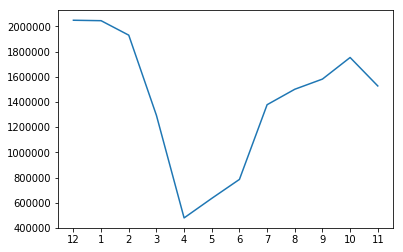

In [21]:
plt.plot([len(last12), len(this1), len(this2), len(this3), len(this4), len(this5), len(this6), len(this7), len(this8), len(this9), len(this10), len(this11)])
plt.xticks(np.arange(12), (12,1,2,3,4,5,6,7,8,9,10,11))

### 2) Demand: Time slot (per half an hour) & Covid stage

In [25]:
df['dt'] = df['session_start_dt'].apply(lambda x: datetime.strptime(x[:19], '%Y-%m-%dT%H:%M:%S'))

In [27]:
df['slot'] = df['dt'].apply(lambda x: int(x.hour) + (0.5 if int(x.minute) < 30 else 1))

In [28]:
def stage(dt):
    if dt < datetime(2020, 3, 15):
        return "before"
    elif (dt >= datetime(2020, 3, 15)) & (dt < datetime(2020,5, 17)):
        return 'shutdown'
    elif (dt >= datetime(2020, 5, 17)) & (dt < datetime(2020,7, 17)):
        return 'reopen'
    elif (dt >= datetime(2020, 7, 17)) & (dt < datetime(2020, 9, 30)):
        return 'closed_due_to_state_re'
    elif (dt >= datetime(2020, 9, 30)) & (dt < datetime(2020, 10, 20)):
        return 'orange'
    elif (dt >= datetime(2020, 10, 20)) & (dt < datetime(2020, 11, 13)):
        return 'yellow'
    elif dt >= datetime(2020, 11, 13):
        return 'rollback'

In [29]:
df['stage'] = df['dt'].apply(lambda x: stage(x))

In [33]:
df.head(5)

,index,post_id,payment_type,session_start_dt,session_end_dt,meter_event_type,gross_paid_amt,BLOCKFACE_ID,dt,slot,stage
0,0,568-26250,CASH,2019-12-01T01:24:31.000,2019-12-01T01:24:31.000,NS,0.25,568261,2019-12-01 01:24:31,1.5,before
1,90102,568-26250,CREDIT CARD,2019-12-03T09:49:07.000,2019-12-03T10:04:07.000,NS,0.63,568261,2019-12-03 09:49:07,10.0,before
2,191976,568-26250,CREDIT CARD,2019-12-04T12:48:22.000,2019-12-04T13:03:22.000,NS,0.69,568261,2019-12-04 12:48:22,13.0,before
3,197631,568-26250,CASH,2019-12-04T13:25:45.000,2019-12-04T13:36:40.000,NS,0.50,568261,2019-12-04 13:25:45,13.5,before
4,197646,568-26250,CASH,2019-12-04T13:25:56.000,2019-12-04T13:40:56.000,NS,0.65,568261,2019-12-04 13:25:56,13.5,before


In [43]:
def avgcount(stage):
    if stage is 'before':
        return 1/105
    elif stage is 'shutdown':
        return 1/63
    elif stage is 'reopen':
        return 1/61
    elif stage is 'closed_due_to_state_re':
        return 1/75
    elif stage is 'orange':
        return 1/20
    elif stage is 'yellow':
        return 1/24
    else:
        return 1/18

In [44]:
df['avg'] = df['stage'].apply(lambda x: avgcount(x))

In [66]:
b = []
st = []
sl = []
for block_ in list(df['BLOCKFACE_ID'].unique()):
    for stage_ in ['before', 'shutdown', 'reopen','closed_due_to_state_re','orange','yellow','rollback']:
        for slot_ in list(np.arange(0.5, 24.5, 0.5)):
            b.append(block_)
            st.append(stage_)
            sl.append(slot_)
fakedata = {'BLOCKFACE_ID':b,
           'stage':st,
           'slot':sl,
           'avg':[0]*7*48*2658}
fakedf = pd.DataFrame(fakedata)

In [70]:
for_demand_agg = pd.concat([fakedf,df[['BLOCKFACE_ID','stage','slot', 'avg']]])

In [75]:
for_demand_agg.groupby(['BLOCKFACE_ID', 'stage', 'slot']).agg(['sum'])

avg
                               sum
BLOCKFACE_ID stage  slot          
102021       before 0.5   0.000000
                    1.0   0.000000
                    1.5   0.000000
                    2.0   0.000000
                    2.5   0.000000
                    3.0   0.000000
                    3.5   0.000000
                    4.0   0.000000
                    4.5   0.000000
                    5.0   0.000000
                    5.5   0.000000
                    6.0   0.000000
                    6.5   0.000000
                    7.0   0.000000
                    7.5   0.000000
                    8.0   0.000000
                    8.5   0.028571
                    9.0   0.171429
                    9.5   0.495238
                    10.0  0.219048
                    10.5  0.323810
                    11.0  0.342857
                    11.5  0.400000
                    12.0  0.457143
                    12.5  0.390476
                    13.0  0.295238
                    13.5  0.238095
                    14.0  0.333333
                    14.5  0.209524
                    15.0  0.314286
...                            ...
878002       yellow 9.5   0.208333
                    10.0  0.375000
                    10.5  0.333333
                    11.0  0.166667
                    11.5  0.666667
                    12.0  0.500000
                    12.5  0.583333
                    13.0  0.958333
                    13.5  0.416667
                    14.0  0.500000
                    14.5  0.375000
                    15.0  0.375000
                    15.5  0.458333
                    16.0  0.208333
                    16.5  0.291667
                    17.0  0.291667
                    17.5  0.125000
                    18.0  0.041667
                    18.5  0.000000
                    19.0  0.041667
                    19.5  0.000000
                    20.0  0.000000
                    20.5  0.000000
                    21.0  0.041667
                    21.5  0.000000
                    22.0  0.000000
                    22.5  0.000000
                    23.0  0.000000
                    23.5  0.000000
                    24.0  0.000000

[893088 rows x 1 columns]

In [76]:
for_demand_agg.to_csv('../../data/demand.csv')